<a href="https://colab.research.google.com/github/melany-rios/Dashboard-DCGC/blob/main/notebooks/g6_pp3_analisis_completo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica Profesionalizante III
## Prof. Mubarqui Fernando
### Carrera: Ciencia de Datos e Inteligencia Artificial
### **Grupo N°6**
### Integrantes:
* Andrade, Miguel Enrique.
* Coronel, Atilio Maximiliano.
* Gimenez, Roberto David.
* Jimenez, Javier Oscar.
* Rios Santillan, Melany Ayelen.

### Institución: Dirección General de Control y Gestión - Policía de Santiago del Estero


### Simulación del Dataset
* Contiene información sobre controles, dependencias, ubicación, funcionarios y armamento.

### Diccionario de Datos

| Columna                   | Tipo de Dato | Descripción                                                                      |
| ------------------------- | ------------ | -------------------------------------------------------------------------------- |
| `id_control`              | int          | Identificador único del control realizado                                        |
| `fecha_control`           | date         | Fecha en la que se realizó el control                                            |
| `dependencia`             | string       | Nombre de la dependencia policial controlada                                     |
| `region`                  | string       | Región geográfica a la que pertenece la dependencia                              |
| `controles_realizados`    | int / NaN    | Número de ítems verificados durante el control                                   |
| `anomalías_detectadas`    | int / NaN    | Cantidad de anomalías encontradas                                                |
| `personal_asistentes`     | int / NaN    | Cantidad de funcionarios que participaron del control                            |
| `legajo`                  | string       | Número de legajo del funcionario responsable                                     |
| `dni`                     | string       | Documento Nacional de Identidad del funcionario                                  |
| `apellido`                | string       | Apellido del funcionario                                                         |
| `nombre`                  | string       | Nombre del funcionario                                                           |
| `fecha_nacimiento`        | date         | Fecha de nacimiento del funcionario                                              |
| `edad`                    | int / NaN    | Edad del funcionario (calculada desde la fecha de nacimiento)                    |
| `jerarquia`               | string       | Jerarquía o cargo del funcionario (según escalafón policial)                     |
| `fecha_ingreso`           | date         | Fecha de ingreso del funcionario a la institución                                |
| `antiguedad_anios`        | int / NaN    | Antigüedad del funcionario en años (calculada desde `fecha_ingreso`)             |
| `estado_funcionario`      | string       | Estado laboral actual del funcionario: `Activo` o `Inactivo`                     |
| `telefono`                | string / NaN | Número de teléfono de contacto (si está disponible)                              |
| `observacion_funcionario` | string / NaN | Observaciones sobre el funcionario (licencias, retiros, etc.)                    |
| `tipo_arma`               | string       | Tipo de arma asignada (Pistola, Escopeta, Fusil, etc.)                           |
| `marca_arma`              | string / NaN | Marca del arma asignada (Bersa, Glock, Remington, etc.)                          |
| `nro_arma`                | string       | Número de serie del arma                                                         |
| `estado_arma`             | string       | Estado operativo del arma (`Operativa`, `En mantenimiento`, `Fuera de servicio`) |
| `observacion_arma`        | string / NaN | Comentarios u observaciones sobre el arma (defectos, revisiones, etc.)           |
| `fecha_asignacion_arma`   | date         | Fecha en que el arma fue asignada al funcionario                                 |
| `fecha_devolucion_arma`   | date / NaN   | Fecha en que el arma fue devuelta (si aplica)                                    |


### Librerias

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

## 1) Selección del Dataset

### Configuración General

In [2]:
np.random.seed(42)
num_registros = 1000

### Definición de Datos Base

In [3]:
jerarquias = [
    'Agente',
    'Cabo', 'Cabo Primero', 'Sargento',
    'Sargento Primero', 'Sargento Ayudante', 'Sargento Principal', 'Suboficial Mayor',
    'Oficial Ayudante', 'Oficial Sub-Inspector', 'Oficial Inspector', 'Oficial Principal',
    'Sub-Comisario', 'Comisario',
    'Comisario Inspector', 'Comisario Mayor', 'Comisario General'
]
# Normalización de probabilidades para jerarquías
prob_jerarquia = np.array([
    0.25, 0.10, 0.08, 0.07, 0.06, 0.05, 0.04, 0.02,
    0.07, 0.05, 0.04, 0.03, 0.02, 0.01, 0.005, 0.003, 0.002
])
prob_jerarquia = prob_jerarquia / prob_jerarquia.sum()

estados_funcionario = ['Activo', 'Inactivo']
prob_estado_funcionario = [0.85, 0.15]

dependencias = [
    'Departamental Nº 1 Zona Norte (Capital)',
    'Departamental Nº 2 Zona Centro (Capital)',
    'Departamental Nº 3 Zona Sur (Capital)',
    'Departamental Nº 4 Zona Oeste (La Banda)',
    'Departamental Nº 5 Zona Este (La Banda)',
    'Departamental Nº 6 Las Termas',
    'Departamental Nº 7 Frías',
    'Departamental Nº 8 Fernández',
    'Departamental Nº 9 Loreto',
    'Departamental Nº 10 Nueva Esperanza',
    'Departamental Nº 11 Monte Quemado',
    'Departamental Nº 12 Quimilí',
    'Departamental Nº 13 Añatuya',
    'Departamental Nº 14 Pinto',
    'Departamental Nº 15 Ojo de Agua',
    'Departamental Nº 16 Los Flores (Capital)'
]

# Extraer región
import re

def extraer_region(dep):
    # Si tiene paréntesis, extraer lo que está dentro
    if '(' in dep:
        return re.search(r'\((.*?)\)', dep).group(1).strip()
    else:
        # Extraer el texto después de 'Departamental Nº XX '
        match = re.search(r'Departamental Nº \d+\s+(.*)', dep)
        if match:
            return match.group(1).strip()
        else:
            return 'Desconocida'


tipos_arma = ['Pistola', 'Escopeta', 'Fusil']
prob_tipos_arma = [0.6, 0.3, 0.1]
marcas_arma = ['Bersa', 'Glock', 'IWI', 'Remington']
estados_arma = ['Operativa', 'En mantenimiento', 'Fuera de servicio']
prob_estados_arma = [0.7, 0.2, 0.1]
nombres = ['Juan', 'Ana', 'Carlos', 'Laura', 'José', 'María', 'Luis', 'Sofía', 'Pedro', 'Lucía']
apellidos = ['Pérez', 'Gómez', 'López', 'Fernández', 'Rodríguez', 'García', 'Martínez', 'Sánchez', 'Díaz', 'Romero']

### Simulación del Dataset

In [4]:
# === Simulación del dataset ===
registros = []
for i in range(1, num_registros + 1):
    fecha_control = datetime.now().date() - timedelta(days=np.random.randint(0, 365))
    dependencia = np.random.choice(dependencias)
    region = extraer_region(dependencia)
    controles_realizados = np.random.poisson(lam=5)
    anomalías_detectadas = np.random.binomial(n=3, p=0.3)
    personal_asistentes = np.random.randint(1, 10)

    # Datos personales
    años_edad = np.random.randint(21, 61)
    fecha_nacimiento = datetime.now().date() - timedelta(days=años_edad * 365 + np.random.randint(0, 365))
    edad = (datetime.now().date() - fecha_nacimiento).days // 365

    # Datos del funcionario responsable
    fecha_ingreso = datetime(2010, 1, 1) + timedelta(days=np.random.randint(0, 5000))
    antiguedad_anios = round((datetime.now().date() - fecha_ingreso.date()).days / 365)

    funcionario = {
        'id_control': i,
        'fecha_control': fecha_control,
        'dependencia': dependencia,
        'region': region,
        'controles_realizados': controles_realizados,
        'anomalías_detectadas': anomalías_detectadas,
        'personal_asistentes': personal_asistentes,
        'legajo': f"LEG{i:04d}",
        'dni': f"{np.random.randint(20000000, 45000000)}",
        'apellido': np.random.choice(apellidos),
        'nombre': np.random.choice(nombres),
        'fecha_nacimiento': fecha_nacimiento,
        'edad': edad,
        'jerarquia': np.random.choice(jerarquias, p=prob_jerarquia),
        'fecha_ingreso': fecha_ingreso.date(),
        'antiguedad_anios': antiguedad_anios,
        'estado_funcionario': np.random.choice(estados_funcionario, p=prob_estado_funcionario),
        'telefono': np.random.choice(['', '3854-XXXXXX', '3855-XXXXXX']),
        'observacion_funcionario': np.random.choice(['', '', 'En licencia médica', 'Próximo a retiro'])
    }

    # Datos del arma asignada
    fecha_asignacion = fecha_control - timedelta(days=np.random.randint(30, 400))
    fecha_devolucion = fecha_asignacion + timedelta(days=np.random.randint(100, 800)) if np.random.rand() < 0.3 else None

    funcionario.update({
        'tipo_arma': np.random.choice(tipos_arma, p=prob_tipos_arma),
        'marca_arma': np.random.choice(marcas_arma),
        'nro_arma': f"ARM-{i:05d}",
        'estado_arma': np.random.choice(estados_arma, p=prob_estados_arma),
        'observacion_arma': np.random.choice(['', '', 'Requiere revisión anual', 'Desgaste en cañón']),
        'fecha_asignacion_arma': fecha_asignacion,
        'fecha_devolucion_arma': fecha_devolucion
    })

    registros.append(funcionario)

### Creación del DataFrame

In [5]:
df = pd.DataFrame(registros)
pd.set_option('display.max_columns', None)
df.head()

,id_control,fecha_control,dependencia,region,controles_realizados,anomalías_detectadas,personal_asistentes,legajo,dni,apellido,nombre,fecha_nacimiento,edad,jerarquia,fecha_ingreso,antiguedad_anios,estado_funcionario,telefono,observacion_funcionario,tipo_arma,marca_arma,nro_arma,estado_arma,observacion_arma,fecha_asignacion_arma,fecha_devolucion_arma
0,1,2025-08-04,Departamental Nº 4 Zona Oeste (La Banda),La Banda,5,2,4,LEG0001,41300885,Rodríguez,Ana,1965-07-01,60,Sargento Principal,2010-05-11,16,Inactivo,3854-XXXXXX,Próximo a retiro,Escopeta,Bersa,ARM-00001,Operativa,,2024-10-02,None
1,2,2025-09-17,Departamental Nº 15 Ojo de Agua,Ojo de Agua,4,0,7,LEG0002,42276936,Martínez,Ana,2002-01-18,23,Oficial Principal,2011-10-09,14,Inactivo,3854-XXXXXX,,Pistola,Remington,ARM-00002,Operativa,,2024-11-27,2026-02-09
2,3,2025-02-24,Departamental Nº 15 Ojo de Agua,Ojo de Agua,4,0,4,LEG0003,39435721,Fernández,Sofía,1976-05-20,49,Sargento Primero,2010-06-11,15,Activo,3854-XXXXXX,Próximo a retiro,Pistola,Bersa,ARM-00003,Operativa,,2024-06-27,None
3,4,2025-03-08,Departamental Nº 12 Quimilí,Quimilí,3,3,8,LEG0004,32719242,López,Juan,2004-07-07,21,Sargento Principal,2014-02-04,12,Activo,3855-XXXXXX,,Fusil,Bersa,ARM-00004,Operativa,,2024-06-21,None
4,5,2025-10-13,Departamental Nº 16 Los Flores (Capital),Capital,6,2,3,LEG0005,42944510,Martínez,Pedro,2004-11-15,21,Sargento Principal,2011-05-18,15,Activo,,En licencia médica,Pistola,Bersa,ARM-00005,Operativa,,2025-07-13,None


### Introducción de NaNs Logicamente

In [6]:
# === NaNs en funcionarios inactivos ===
df.loc[df['estado_funcionario'] == 'Inactivo', ['telefono', 'observacion_funcionario']] = np.nan

# === NaNs en observaciones de armas operativas (70% sin observación) ===
mask_op = df['estado_arma'] == 'Operativa'
n_op = mask_op.sum()
df.loc[mask_op, 'observacion_arma'] = np.where(
    np.random.rand(n_op) < 0.7,
    np.nan,
    df.loc[mask_op, 'observacion_arma']
)

# === NaNs en fecha de devolución si el arma está operativa (aún no devuelta) ===
df.loc[df['estado_arma'] == 'Operativa', 'fecha_devolucion_arma'] = np.nan

# === NaNs aleatorios en variables de control (simulan errores de carga) ===
for col in ['controles_realizados', 'anomalías_detectadas', 'personal_asistentes']:
    df.loc[np.random.choice(df.index, size=10, replace=False), col] = np.nan

# === NaNs aleatorios en antigüedad y edad ===
df.loc[np.random.choice(df.index, 8, replace=False), 'antiguedad_anios'] = np.nan
df.loc[np.random.choice(df.index, 5, replace=False), 'edad'] = np.nan

In [7]:
df.isnull().sum()

,0
id_control,0
fecha_control,0
dependencia,0
region,0
controles_realizados,10
anomalías_detectadas,10
personal_asistentes,10
legajo,0
dni,0
apellido,0


### Inserción de Outliers

In [8]:
# === Outliers (valores atípicos reales o simulados) ===
outlier_indices = np.random.choice(df.index, 5, replace=False)
df.loc[outlier_indices[:2], 'controles_realizados'] = [50, 100]      # inspecciones masivas
df.loc[outlier_indices[2:4], 'anomalías_detectadas'] = [10, 15]      # anomalías excepcionales
df.loc[outlier_indices[4:], 'personal_asistentes'] = [25]            # dotación inusualmente alta

### Exportación del CSV

In [9]:
df.to_csv('dataset_controles.csv', index=False)

### Muestra del Dataset Generado

In [10]:
pd.set_option('display.max_columns', None)
print("Dataset Dirección General de Control y Gestión - Policía de Santiago del Estero:")
df.head()

Dataset Dirección General de Control y Gestión - Policía de Santiago del Estero:


,id_control,fecha_control,dependencia,region,controles_realizados,anomalías_detectadas,personal_asistentes,legajo,dni,apellido,nombre,fecha_nacimiento,edad,jerarquia,fecha_ingreso,antiguedad_anios,estado_funcionario,telefono,observacion_funcionario,tipo_arma,marca_arma,nro_arma,estado_arma,observacion_arma,fecha_asignacion_arma,fecha_devolucion_arma
0,1,2025-08-04,Departamental Nº 4 Zona Oeste (La Banda),La Banda,5.0,2.0,4.0,LEG0001,41300885,Rodríguez,Ana,1965-07-01,60.0,Sargento Principal,2010-05-11,16.0,Inactivo,NaN,NaN,Escopeta,Bersa,ARM-00001,Operativa,NaN,2024-10-02,NaN
1,2,2025-09-17,Departamental Nº 15 Ojo de Agua,Ojo de Agua,4.0,0.0,7.0,LEG0002,42276936,Martínez,Ana,2002-01-18,23.0,Oficial Principal,2011-10-09,14.0,Inactivo,NaN,NaN,Pistola,Remington,ARM-00002,Operativa,NaN,2024-11-27,NaN
2,3,2025-02-24,Departamental Nº 15 Ojo de Agua,Ojo de Agua,4.0,0.0,4.0,LEG0003,39435721,Fernández,Sofía,1976-05-20,49.0,Sargento Primero,2010-06-11,15.0,Activo,3854-XXXXXX,Próximo a retiro,Pistola,Bersa,ARM-00003,Operativa,,2024-06-27,NaN
3,4,2025-03-08,Departamental Nº 12 Quimilí,Quimilí,3.0,3.0,8.0,LEG0004,32719242,López,Juan,2004-07-07,21.0,Sargento Principal,2014-02-04,12.0,Activo,3855-XXXXXX,,Fusil,Bersa,ARM-00004,Operativa,NaN,2024-06-21,NaN
4,5,2025-10-13,Departamental Nº 16 Los Flores (Capital),Capital,6.0,2.0,3.0,LEG0005,42944510,Martínez,Pedro,2004-11-15,21.0,Sargento Principal,2011-05-18,15.0,Activo,,En licencia médica,Pistola,Bersa,ARM-00005,Operativa,,2025-07-13,NaN


## 2) Análisis Exploratorio de Datos

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Estilo visual
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [13]:
print("Cantidad de filas y columnas que tiene el dataset:")
df.shape

Cantidad de filas y columnas que tiene el dataset:


(1000, 26)

In [14]:
print("Columnas del dataset:")
df.columns

Columnas del dataset:


Index(['id_control', 'fecha_control', 'dependencia', 'region',
       'controles_realizados', 'anomalías_detectadas', 'personal_asistentes',
       'legajo', 'dni', 'apellido', 'nombre', 'fecha_nacimiento', 'edad',
       'jerarquia', 'fecha_ingreso', 'antiguedad_anios', 'estado_funcionario',
       'telefono', 'observacion_funcionario', 'tipo_arma', 'marca_arma',
       'nro_arma', 'estado_arma', 'observacion_arma', 'fecha_asignacion_arma',
       'fecha_devolucion_arma'],
      dtype='object')

In [15]:
print("Tipos de datos de cada columna:")
df.info()

Tipos de datos de cada columna:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_control               1000 non-null   int64  
 1   fecha_control            1000 non-null   object 
 2   dependencia              1000 non-null   object 
 3   region                   1000 non-null   object 
 4   controles_realizados     990 non-null    float64
 5   anomalías_detectadas     990 non-null    float64
 6   personal_asistentes      990 non-null    float64
 7   legajo                   1000 non-null   object 
 8   dni                      1000 non-null   object 
 9   apellido                 1000 non-null   object 
 10  nombre                   1000 non-null   object 
 11  fecha_nacimiento         1000 non-null   object 
 12  edad                     995 non-null    float64
 13  jerarquia                1000 non-null   object

In [16]:
print("Valores nulos en el dataset:")
df.isnull().sum()

Valores nulos en el dataset:


,0
id_control,0
fecha_control,0
dependencia,0
region,0
controles_realizados,10
anomalías_detectadas,10
personal_asistentes,10
legajo,0
dni,0
apellido,0


In [17]:
print("Descripción estadística de las columnas numéricas:")
df.describe()

Descripción estadística de las columnas numéricas:


,id_control,controles_realizados,anomalías_detectadas,personal_asistentes,edad,antiguedad_anios
count,1000.000000,990.000000,990.000000,990.000000,995.000000,992.000000
mean,500.500000,5.091919,0.919192,5.202020,40.333668,8.930444
std,288.819436,3.994262,0.969471,2.625148,11.547349,3.985620
min,1.000000,0.000000,0.000000,1.000000,21.000000,2.000000
25%,250.750000,3.000000,0.000000,3.000000,30.000000,6.000000
50%,500.500000,5.000000,1.000000,5.000000,40.000000,9.000000
75%,750.250000,6.000000,1.000000,7.000000,50.000000,12.000000
max,1000.000000,100.000000,15.000000,25.000000,60.000000,16.000000


/tmp/ipython-input-3906378948.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=missing.values, y=missing.index, palette="crest")


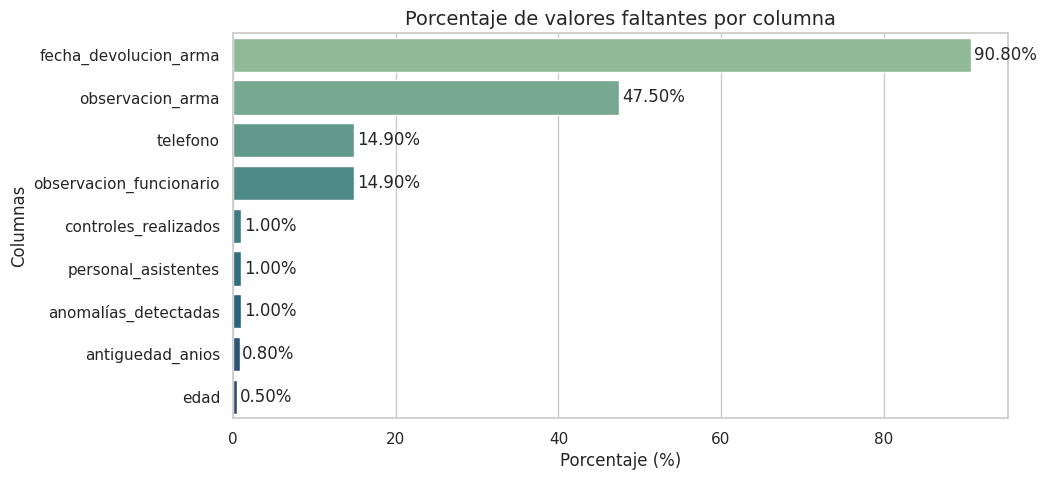

In [18]:
# Distribución de valores nulos por columna (en %)
missing = df.isnull().mean() * 100
missing = missing[missing > 0].sort_values(ascending=False)

plt.figure(figsize=(10,5))
ax = sns.barplot(x=missing.values, y=missing.index, palette="crest")

# Agregar etiquetas con el porcentaje en cada barra
for i, v in enumerate(missing.values):
    ax.text(v + 0.3, i, f"{v:.2f}%", va='center')

plt.title("Porcentaje de valores faltantes por columna", fontsize=14)
plt.xlabel("Porcentaje (%)")
plt.ylabel("Columnas")
plt.show()

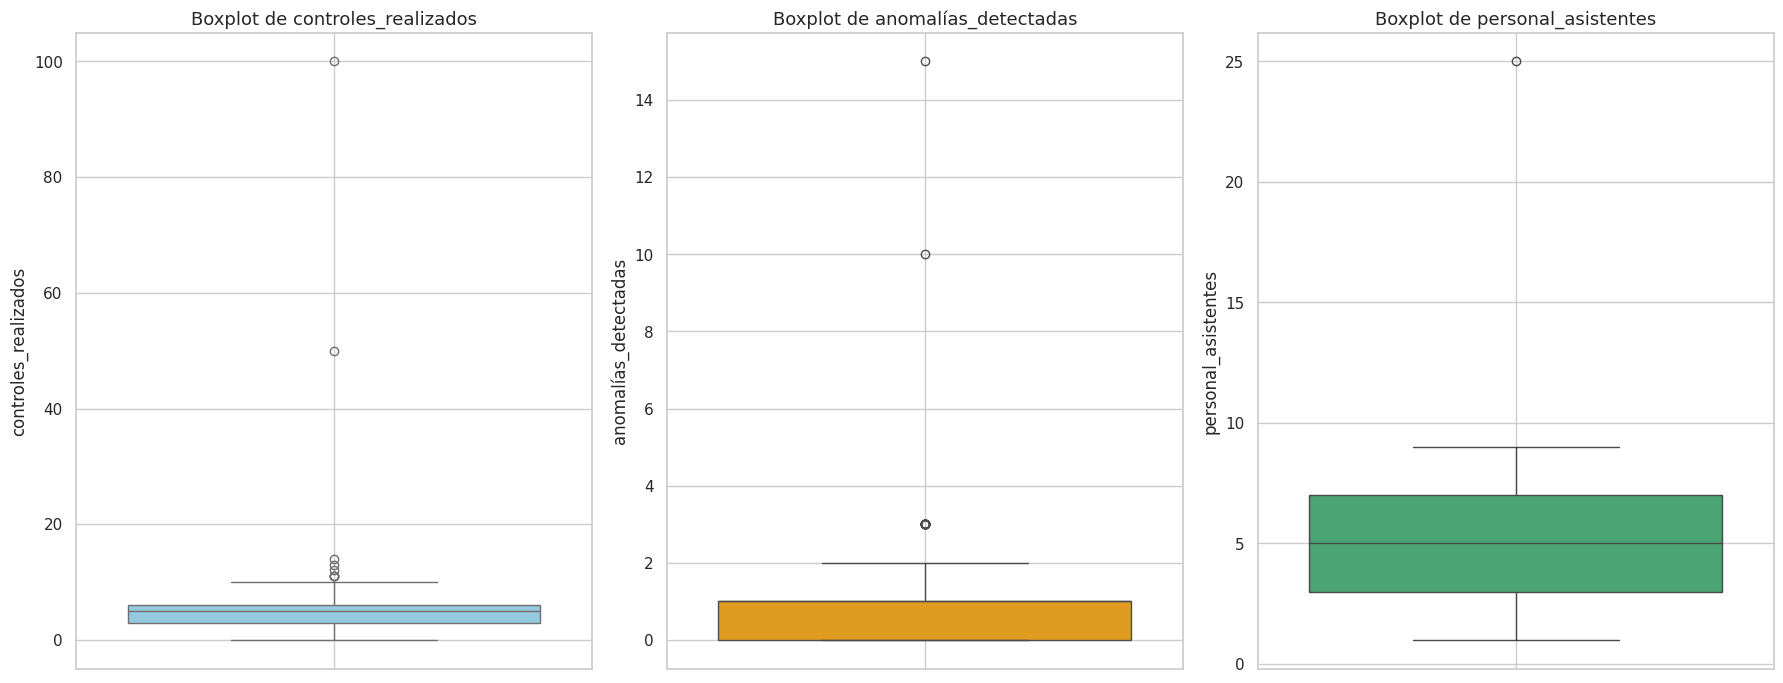

In [19]:
# Boxplots para detección de outliers
cols = ['controles_realizados', 'anomalías_detectadas', 'personal_asistentes']
colores = ['skyblue', 'orange', 'mediumseagreen']

# Crear una figura con 1 fila y 3 columnas de subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 7))  # 1 fila, 3 columnas

# Iterar para crear cada boxplot
for i, col in enumerate(cols):
    sns.boxplot(y=df[col], ax=axes[i], color=colores[i])
    axes[i].set_title(f"Boxplot de {col}", fontsize=13)
    axes[i].set_ylabel(col)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

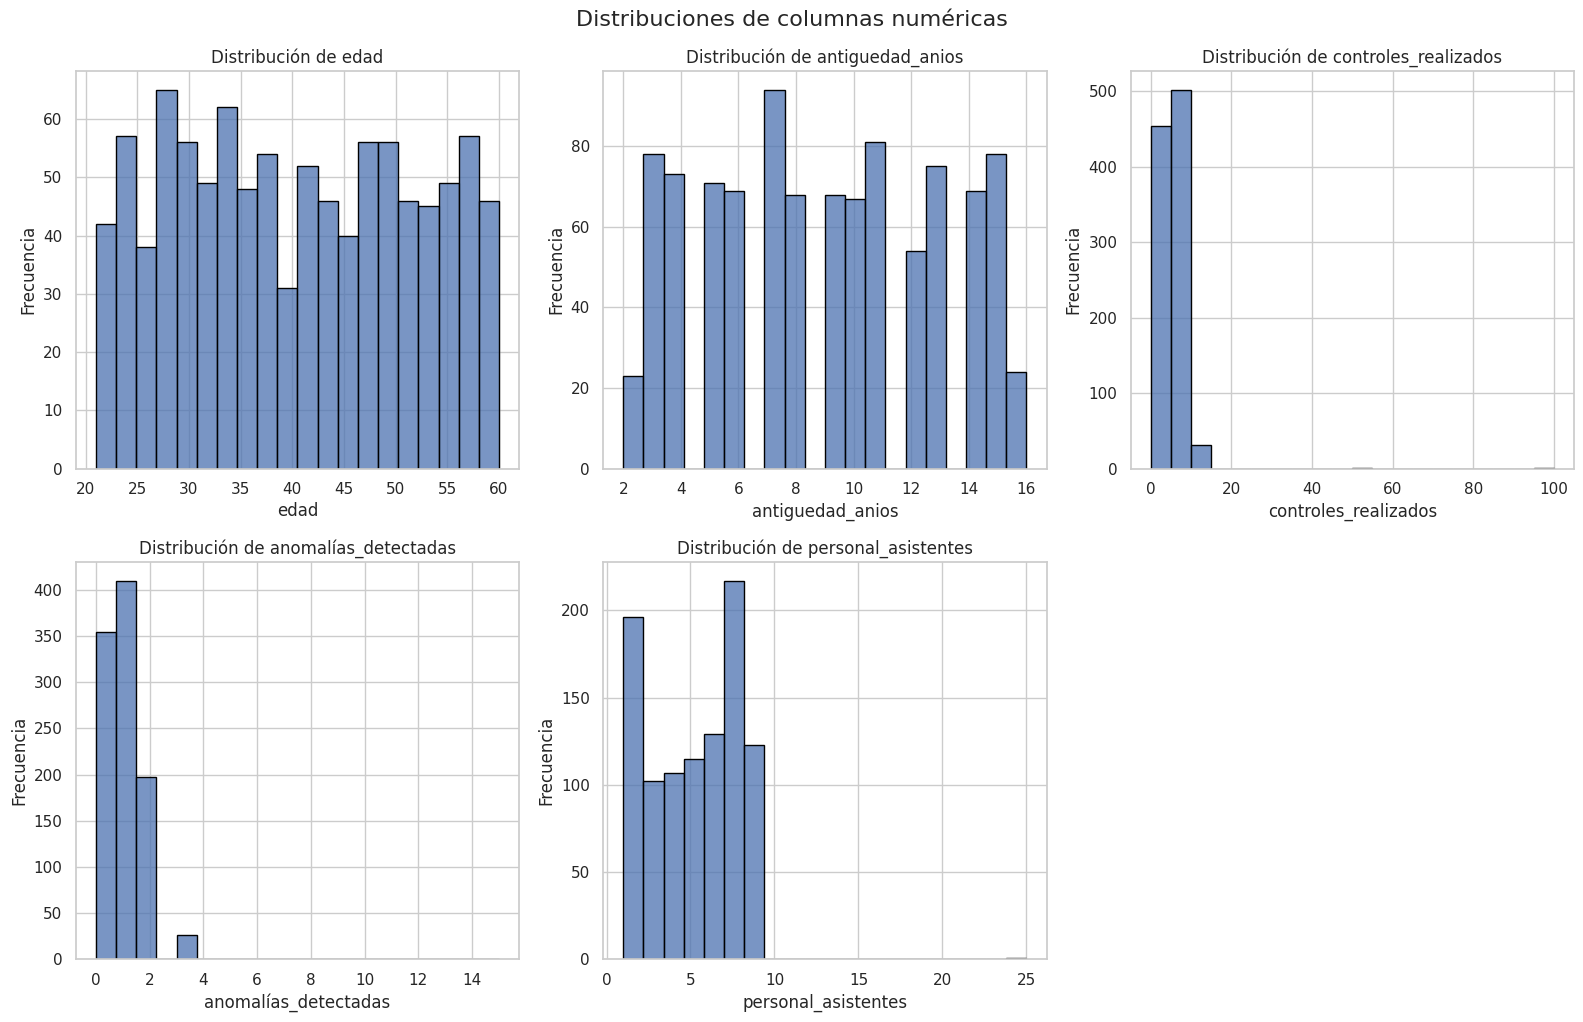

In [20]:
num_cols = ['edad', 'antiguedad_anios', 'controles_realizados', 'anomalías_detectadas', 'personal_asistentes']

plt.figure(figsize=(16, 10))

for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=20, edgecolor="black")
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.suptitle("Distribuciones de columnas numéricas", fontsize=16, y=1.02)
plt.show()

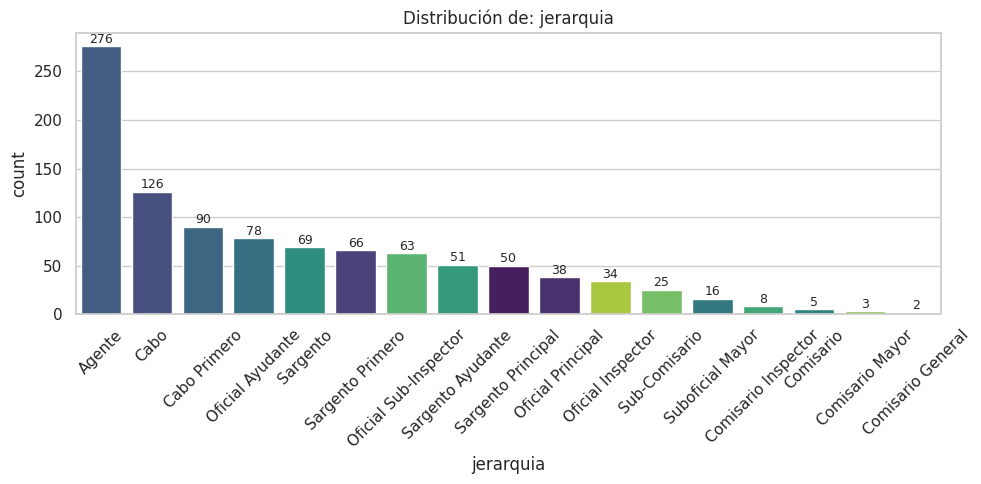

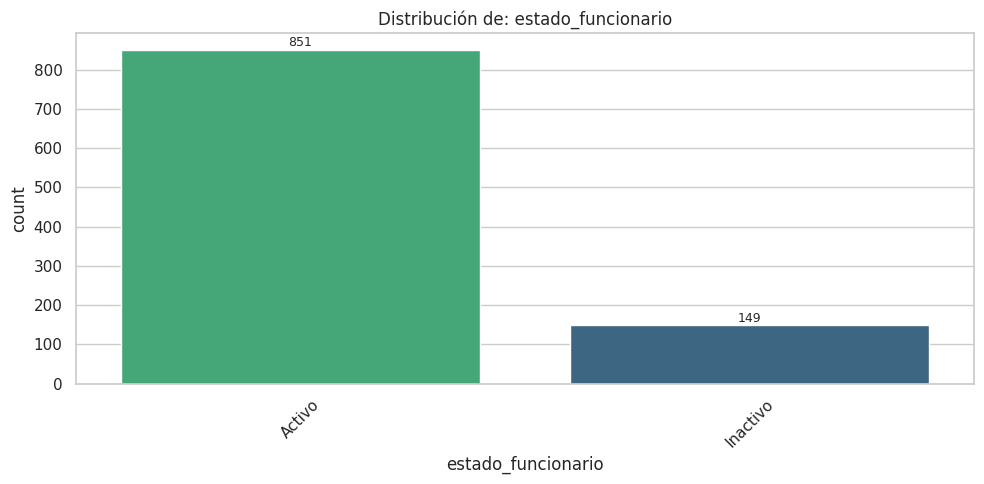

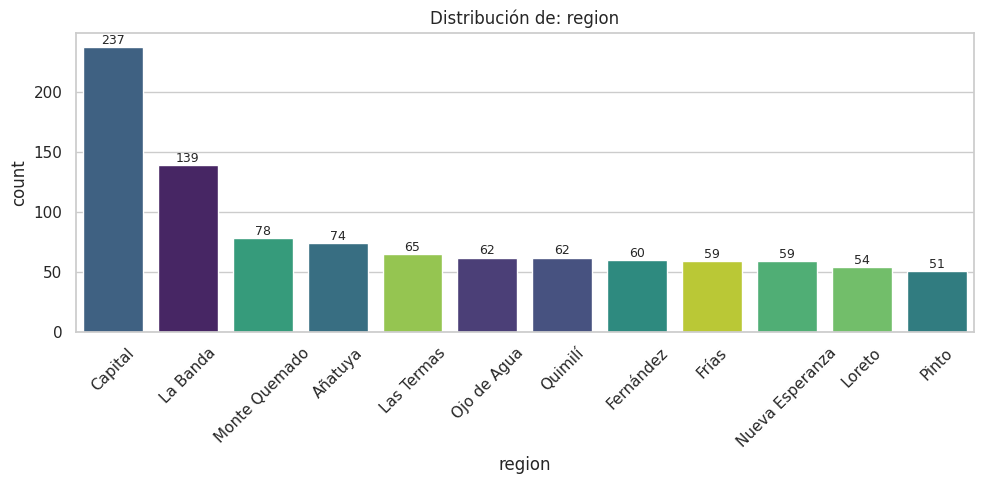

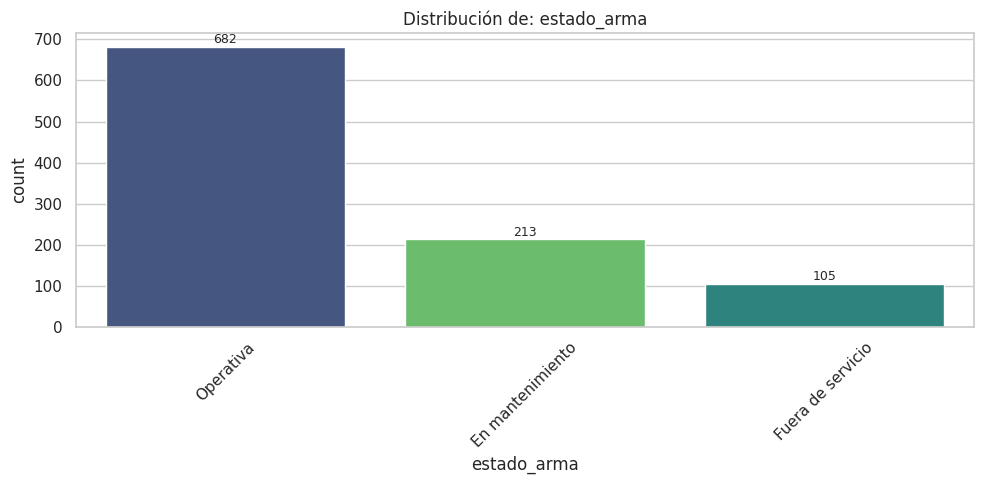

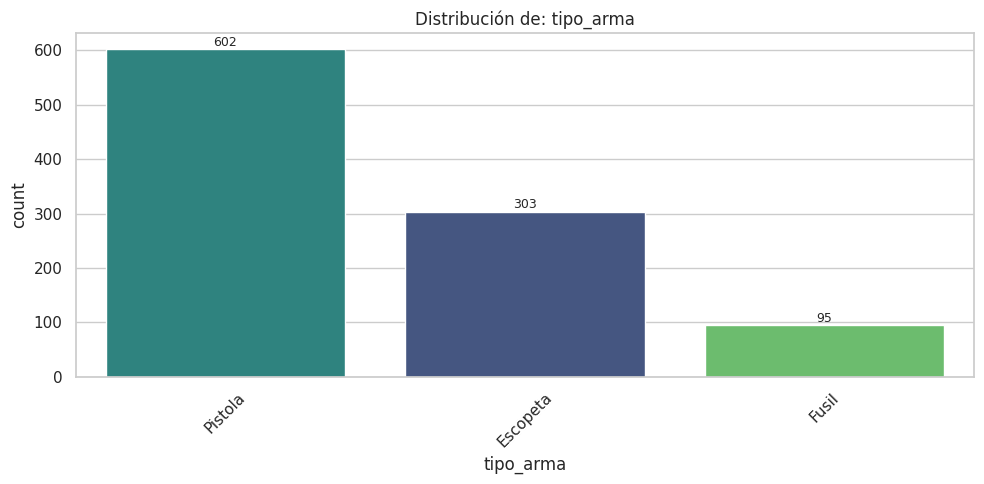

In [21]:
# Columnas categóricas (barras) con valores numéricos
cat_cols = ['jerarquia', 'estado_funcionario', 'region', 'estado_arma', 'tipo_arma']

for col in cat_cols:
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(data=df, x=col,
                     order=df[col].value_counts().index,
                     palette="viridis",
                     hue=col,
                     legend=False)

    # Etiquetas con los valores absolutos
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center',
                   va='center',
                   xytext=(0, 5),
                   textcoords='offset points',
                   fontsize=9)

    plt.xticks(rotation=45)
    plt.title(f"Distribución de: {col}")
    plt.tight_layout()
    plt.show()

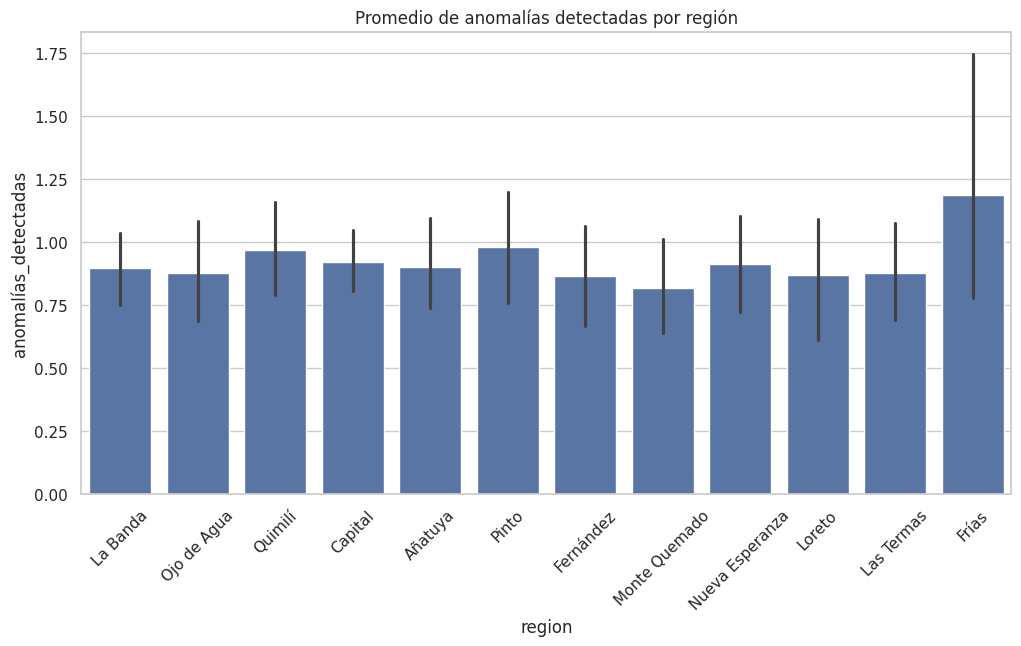

In [22]:
# Comparativa: anomalías por región
plt.figure()
sns.barplot(data=df, x='region', y='anomalías_detectadas', estimator=np.mean)
plt.xticks(rotation=45)
plt.title("Promedio de anomalías detectadas por región")
plt.show()

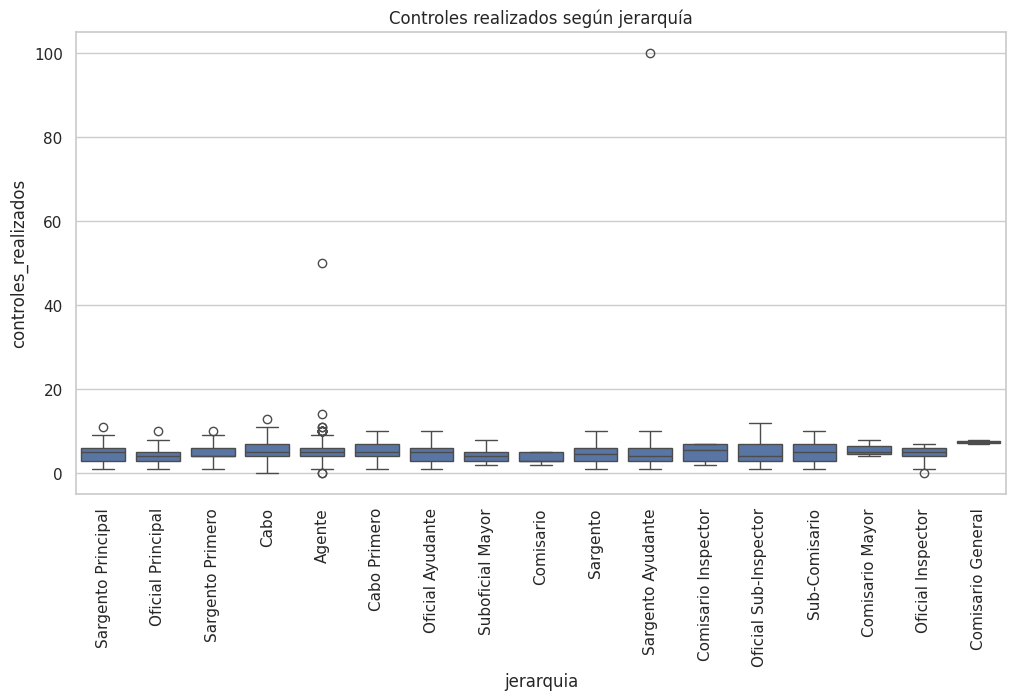

In [23]:
# Relación jerarquía - controles
plt.figure()
sns.boxplot(data=df, x='jerarquia', y='controles_realizados')
plt.xticks(rotation=90)
plt.title("Controles realizados según jerarquía")
plt.show()

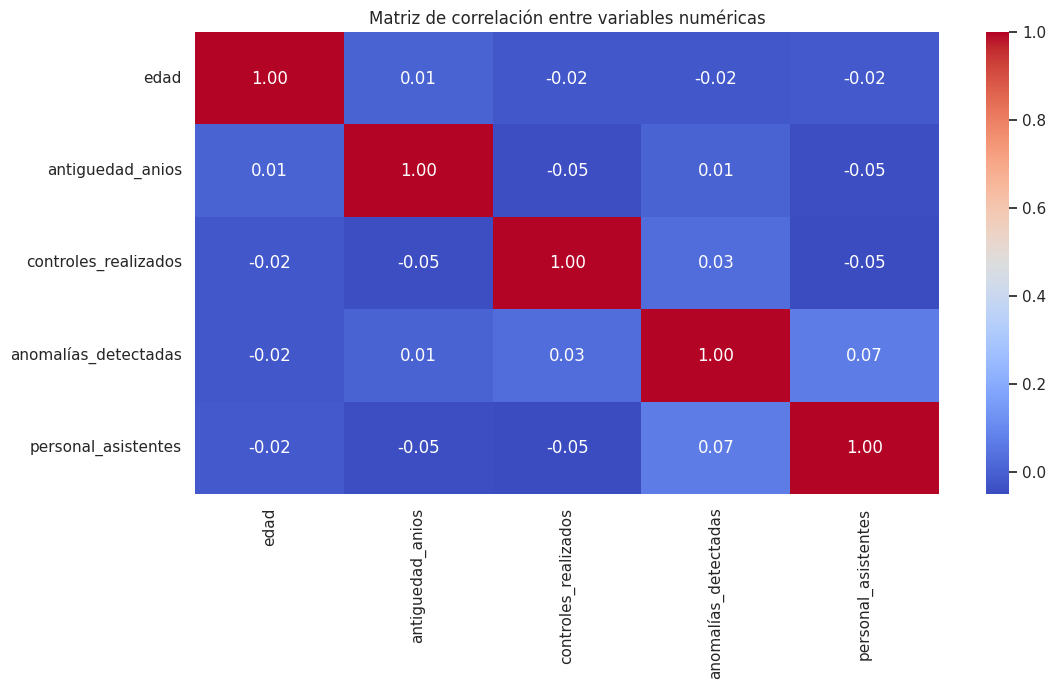

In [24]:
# Correlación entre variables numéricas
plt.figure()
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

## 3) Limpieza y Transformación de Datos

### Copia del Dataset Original

In [25]:
df_limpio = df.copy()

### Tratamiento de Valores Nulos

In [26]:
print("Cantidad de NaNs por columna (antes del tratamiento):")
print(df_limpio.isnull().sum())

Cantidad de NaNs por columna (antes del tratamiento):
id_control                   0
fecha_control                0
dependencia                  0
region                       0
controles_realizados        10
anomalías_detectadas        10
personal_asistentes         10
legajo                       0
dni                          0
apellido                     0
nombre                       0
fecha_nacimiento             0
edad                         5
jerarquia                    0
fecha_ingreso                0
antiguedad_anios             8
estado_funcionario           0
telefono                   149
observacion_funcionario    149
tipo_arma                    0
marca_arma                   0
nro_arma                     0
estado_arma                  0
observacion_arma           475
fecha_asignacion_arma        0
fecha_devolucion_arma      908
dtype: int64


In [27]:
# Reemplazo lógico de valores faltantes
df_limpio['controles_realizados'].fillna(df_limpio['controles_realizados'].median(), inplace=True)
df_limpio['anomalías_detectadas'].fillna(0, inplace=True)
df_limpio['personal_asistentes'].fillna(df_limpio['personal_asistentes'].mode()[0], inplace=True)
df_limpio['edad'].fillna(df_limpio['edad'].median(), inplace=True)
df_limpio['antiguedad_anios'].fillna(df_limpio['antiguedad_anios'].median(), inplace=True)
df_limpio['observacion_funcionario'].fillna('Sin observación', inplace=True)
df_limpio['telefono'].fillna('Sin teléfono', inplace=True)
df_limpio['marca_arma'].fillna('Desconocida', inplace=True)
df_limpio['observacion_arma'].fillna('Sin observación', inplace=True)

/tmp/ipython-input-760607450.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_limpio['controles_realizados'].fillna(df_limpio['controles_realizados'].median(), inplace=True)
/tmp/ipython-input-760607450.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

In [28]:
df_limpio.isnull().sum()

,0
id_control,0
fecha_control,0
dependencia,0
region,0
controles_realizados,0
anomalías_detectadas,0
personal_asistentes,0
legajo,0
dni,0
apellido,0


### Transformación de Tipos de Datos

In [29]:
df_limpio['fecha_control'] = pd.to_datetime(df_limpio['fecha_control'])
df_limpio['fecha_ingreso'] = pd.to_datetime(df_limpio['fecha_ingreso'])
df_limpio['fecha_nacimiento'] = pd.to_datetime(df_limpio['fecha_nacimiento'])
df_limpio['fecha_asignacion_arma'] = pd.to_datetime(df_limpio['fecha_asignacion_arma'])
df_limpio['fecha_devolucion_arma'] = pd.to_datetime(df_limpio['fecha_devolucion_arma'])

### Normalización / estandarización

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_limpio[['edad_norm', 'antiguedad_norm']] = scaler.fit_transform(df_limpio[['edad', 'antiguedad_anios']])

### Creación de nuevas columnas útiles

In [31]:
df_limpio['arma_devuelta'] = df_limpio['fecha_devolucion_arma'].notnull()
df_limpio['anomalías_por_control'] = df_limpio['anomalías_detectadas'] / df_limpio['controles_realizados']
df_limpio['anomalías_por_control'].fillna(0, inplace=True)

df_limpio['categoria_antiguedad'] = pd.cut(df_limpio['antiguedad_anios'],
                                           bins=[0, 5, 10, 20, 40],
                                           labels=['<5 años', '5-10', '10-20', '20+'])

/tmp/ipython-input-2142503344.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_limpio['anomalías_por_control'].fillna(0, inplace=True)


In [32]:
df_limpio.head()

,id_control,fecha_control,dependencia,region,controles_realizados,anomalías_detectadas,personal_asistentes,legajo,dni,apellido,nombre,fecha_nacimiento,edad,jerarquia,fecha_ingreso,antiguedad_anios,estado_funcionario,telefono,observacion_funcionario,tipo_arma,marca_arma,nro_arma,estado_arma,observacion_arma,fecha_asignacion_arma,fecha_devolucion_arma,edad_norm,antiguedad_norm,arma_devuelta,anomalías_por_control,categoria_antiguedad
0,1,2025-08-04,Departamental Nº 4 Zona Oeste (La Banda),La Banda,5.0,2.0,4.0,LEG0001,41300885,Rodríguez,Ana,1965-07-01,60.0,Sargento Principal,2010-05-11,16.0,Inactivo,Sin teléfono,Sin observación,Escopeta,Bersa,ARM-00001,Operativa,Sin observación,2024-10-02,NaT,1.000000,1.000000,False,0.400000,10-20
1,2,2025-09-17,Departamental Nº 15 Ojo de Agua,Ojo de Agua,4.0,0.0,7.0,LEG0002,42276936,Martínez,Ana,2002-01-18,23.0,Oficial Principal,2011-10-09,14.0,Inactivo,Sin teléfono,Sin observación,Pistola,Remington,ARM-00002,Operativa,Sin observación,2024-11-27,NaT,0.051282,0.857143,False,0.000000,10-20
2,3,2025-02-24,Departamental Nº 15 Ojo de Agua,Ojo de Agua,4.0,0.0,4.0,LEG0003,39435721,Fernández,Sofía,1976-05-20,49.0,Sargento Primero,2010-06-11,15.0,Activo,3854-XXXXXX,Próximo a retiro,Pistola,Bersa,ARM-00003,Operativa,,2024-06-27,NaT,0.717949,0.928571,False,0.000000,10-20
3,4,2025-03-08,Departamental Nº 12 Quimilí,Quimilí,3.0,3.0,8.0,LEG0004,32719242,López,Juan,2004-07-07,21.0,Sargento Principal,2014-02-04,12.0,Activo,3855-XXXXXX,,Fusil,Bersa,ARM-00004,Operativa,Sin observación,2024-06-21,NaT,0.000000,0.714286,False,1.000000,10-20
4,5,2025-10-13,Departamental Nº 16 Los Flores (Capital),Capital,6.0,2.0,3.0,LEG0005,42944510,Martínez,Pedro,2004-11-15,21.0,Sargento Principal,2011-05-18,15.0,Activo,,En licencia médica,Pistola,Bersa,ARM-00005,Operativa,,2025-07-13,NaT,0.000000,0.928571,False,0.333333,10-20


###Codificación de variables categóricas (para Machine Learning)

In [33]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df_limpio.copy()
label_cols = ['jerarquia', 'estado_funcionario', 'estado_arma', 'tipo_arma', 'region']
label_encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df_encoded[f'{col}_enc'] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Visualizar columnas nuevas generadas
print("\n Columnas después de transformación:")
print(df_encoded.columns)


 Columnas después de transformación:
Index(['id_control', 'fecha_control', 'dependencia', 'region',
       'controles_realizados', 'anomalías_detectadas', 'personal_asistentes',
       'legajo', 'dni', 'apellido', 'nombre', 'fecha_nacimiento', 'edad',
       'jerarquia', 'fecha_ingreso', 'antiguedad_anios', 'estado_funcionario',
       'telefono', 'observacion_funcionario', 'tipo_arma', 'marca_arma',
       'nro_arma', 'estado_arma', 'observacion_arma', 'fecha_asignacion_arma',
       'fecha_devolucion_arma', 'edad_norm', 'antiguedad_norm',
       'arma_devuelta', 'anomalías_por_control', 'categoria_antiguedad',
       'jerarquia_enc', 'estado_funcionario_enc', 'estado_arma_enc',
       'tipo_arma_enc', 'region_enc'],
      dtype='object')


### Exportación del CSV limpio

In [34]:
df.to_csv('dataset_final.csv', index=False)

# 4) Generación de CSV Anonimizados para Dashboard (Streamlit)

Esta sección genera los datasets finales que serán utilizados por el dashboard desarrollado en Streamlit Cloud.

El flujo es el siguiente:
1. Partimos del dataset limpio (df_limpio) generado en la sección anterior.
2. Aplicamos anonimización para proteger todos los datos sensibles.
3. Dividimos el dataset en dos archivos separados:
    * rrhh_dependencias.csv
    * armamento.csv
4. Exportamos los CSV anonimizados para subirlos manualmente al repositorio de GitHub.

### Anonimización de Datos Sensibles

Para cumplir los requisitos de privacidad, los datos sensibles del personal deben anonimizarse antes de ser utilizados en cualquier dashboard público.

Los siguientes campos serán reemplazados por un **hash SHA-256** con "salt", generando valores irreversibles:
* DNI
* Legajo
* Nombre
* Apellido
* Teléfono

Estas columnas serán eliminadas y reemplazadas por:
* `dni_hashed`
* `legajo_hashed`
* `nombre_hashed`
* `apellido_hashed`
* `telefono_hashed`

In [35]:
import hashlib
import pandas as pd

# Función de hashing con salt seguro
def hash_value(value, salt="seguridad2024"):
    if pd.isna(value) or value == "":
        return None
    value = str(value) + salt
    return hashlib.sha256(value.encode()).hexdigest()

# Crear copia del dataset limpio para generar la versión anonimizada
df_anon = df_limpio.copy()

# Aplicar anonimización a los campos sensibles
df_anon['dni_hashed'] = df_anon['dni'].apply(hash_value)
df_anon['legajo_hashed'] = df_anon['legajo'].apply(hash_value)
df_anon['nombre_hashed'] = df_anon['nombre'].apply(hash_value)
df_anon['apellido_hashed'] = df_anon['apellido'].apply(hash_value)
df_anon['telefono_hashed'] = df_anon['telefono'].apply(hash_value)

# Eliminar columnas sensibles originales
df_anon = df_anon.drop(columns=[
    'dni', 'legajo', 'nombre', 'apellido', 'telefono'
])

df_anon.head()

,id_control,fecha_control,dependencia,region,controles_realizados,anomalías_detectadas,personal_asistentes,fecha_nacimiento,edad,jerarquia,fecha_ingreso,antiguedad_anios,estado_funcionario,observacion_funcionario,tipo_arma,marca_arma,nro_arma,estado_arma,observacion_arma,fecha_asignacion_arma,fecha_devolucion_arma,edad_norm,antiguedad_norm,arma_devuelta,anomalías_por_control,categoria_antiguedad,dni_hashed,legajo_hashed,nombre_hashed,apellido_hashed,telefono_hashed
0,1,2025-08-04,Departamental Nº 4 Zona Oeste (La Banda),La Banda,5.0,2.0,4.0,1965-07-01,60.0,Sargento Principal,2010-05-11,16.0,Inactivo,Sin observación,Escopeta,Bersa,ARM-00001,Operativa,Sin observación,2024-10-02,NaT,1.000000,1.000000,False,0.400000,10-20,2a553d95fb373547899b701af1cb01bb02f16f73e0a61f...,af76454cd76f1023048606a03e9b12a576d6f059c5600d...,c10120abd4bd6c7afa4ceecb27968153845932835fac9a...,9313f82fc018baa14436d316f85fe1b3f4a0ddd674c76d...,fad96425aa34141975fd8f74f8e77941615da6956ebcec...
1,2,2025-09-17,Departamental Nº 15 Ojo de Agua,Ojo de Agua,4.0,0.0,7.0,2002-01-18,23.0,Oficial Principal,2011-10-09,14.0,Inactivo,Sin observación,Pistola,Remington,ARM-00002,Operativa,Sin observación,2024-11-27,NaT,0.051282,0.857143,False,0.000000,10-20,86b8c341fd1a8e9cf6eb0d0ad358ef50192c2e9adea94b...,b5f1ac10c7c51c5d8e6d18d943bf9ae8bedc0687bfe5d4...,c10120abd4bd6c7afa4ceecb27968153845932835fac9a...,f3739d22e4c7afe1cb580a2cdeb3d55c8f762f01dcb743...,fad96425aa34141975fd8f74f8e77941615da6956ebcec...
2,3,2025-02-24,Departamental Nº 15 Ojo de Agua,Ojo de Agua,4.0,0.0,4.0,1976-05-20,49.0,Sargento Primero,2010-06-11,15.0,Activo,Próximo a retiro,Pistola,Bersa,ARM-00003,Operativa,,2024-06-27,NaT,0.717949,0.928571,False,0.000000,10-20,a2106b326a83300d6f5705aba9cba241eceb3c76f989d7...,e61296c083ccd95e8f79bdd4496eb330ee1629ef9673e1...,778bf762d3f9313351f645d5a07f2c6504456508d522cc...,f39f4b8c70b981d3a281675c13863ccd3f67af328e430f...,c85760261ce6319a04aef24d586c4ab858dc4a26818639...
3,4,2025-03-08,Departamental Nº 12 Quimilí,Quimilí,3.0,3.0,8.0,2004-07-07,21.0,Sargento Principal,2014-02-04,12.0,Activo,,Fusil,Bersa,ARM-00004,Operativa,Sin observación,2024-06-21,NaT,0.000000,0.714286,False,1.000000,10-20,f430391abd6feac39b8945edf7eaaec084938dbf6aa2d0...,eb715055441a1478158944df70adc4a756f0f26f93b6f2...,f4d5a3d6e242a7099484e5b1e9a6507a2c5e4ae5b0f0fe...,980ae82081d79f267ce0b1538fbcd30a60ddbd4a338313...,bf94d92b43ee930667dd7cedf533a0014cfd736d49811a...
4,5,2025-10-13,Departamental Nº 16 Los Flores (Capital),Capital,6.0,2.0,3.0,2004-11-15,21.0,Sargento Principal,2011-05-18,15.0,Activo,En licencia médica,Pistola,Bersa,ARM-00005,Operativa,,2025-07-13,NaT,0.000000,0.928571,False,0.333333,10-20,8bdf66843532b5270c28983061165cf00833df08215336...,b3ef50fdd70e361972b44864818cc7acf96cf7002103ef...,11a3e02d5fe9e3baabe1f391a5ecba9271cb03b4277b43...,f3739d22e4c7afe1cb580a2cdeb3d55c8f762f01dcb743...,None


### Generación de CSV separados para el Dashboard

Creamos dos CSV:

1️⃣ **RRHH + Dependencias**

Incluye datos del personal, jerarquías, regiones y estado.

2️⃣ **Armamento**

Registra armas asignadas, tipo, estado, y fechas relevantes.

In [36]:
import os

# ---- CSV de RRHH + Dependencias ----
columnas_rrhh = [
    'dni_hashed', 'legajo_hashed',
    'nombre_hashed', 'apellido_hashed', 'telefono_hashed',
    'edad', 'jerarquia', 'fecha_nacimiento', 'fecha_ingreso',
    'antiguedad_anios', 'estado_funcionario',
    'dependencia', 'region'
]

df_rrhh = df_anon[columnas_rrhh].copy()

# ---- CSV de Armamento ----
columnas_armamento = [
    'dni_hashed', 'legajo_hashed',
    'tipo_arma', 'marca_arma', 'nro_arma',
    'estado_arma', 'observacion_arma',
    'fecha_asignacion_arma', 'fecha_devolucion_arma',
    'dependencia', 'region'
]

df_armamento = df_anon[columnas_armamento].copy()

# Crear carpeta temporal para almacenar los CSVs
os.makedirs("/content/csv_dashboard", exist_ok=True)

# Guardar archivos CSV
df_rrhh.to_csv("/content/csv_dashboard/rrhh_dependencias.csv", index=False)
df_armamento.to_csv("/content/csv_dashboard/armamento.csv", index=False)

print("Archivos generados correctamente:")
print(" - rrhh_dependencias.csv")
print(" - armamento.csv")

Archivos generados correctamente:
 - rrhh_dependencias.csv
 - armamento.csv


### Descarga de los CSV (para subir manualmente a GitHub)

In [37]:
from google.colab import files

print("Descargando CSV de RRHH...")
files.download("/content/csv_dashboard/rrhh_dependencias.csv")

print("Descargando CSV de Armamento...")
files.download("/content/csv_dashboard/armamento.csv")

Descargando CSV de RRHH...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Descargando CSV de Armamento...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_rrhh.head(), df_armamento.head()

## 4) Storytelling: Análisis Narrativo del Dataset

### ¿Qué se analizó y por qué?

El presente análisis forma parte del Trabajo de Práctica Profesionalizante de la carrera de Ciencia de Datos e Inteligencia Artificial. Se desarrolló un **dataset simulado pero realista** basado en el funcionamiento de la **Dirección General de Control y Gestión de la Policía de Santiago del Estero**, con el objetivo de aplicar técnicas de análisis exploratorio, limpieza y preparación de datos para futuros modelos predictivos o sistemas de soporte a decisiones.

El dataset integra información clave sobre:
- **Controles realizados** en distintas **dependencias policiales**,
- Datos **demográficos y jerárquicos** de los **funcionarios** responsables,
- Asignación y estado de **recursos materiales (armas)**.

Esta información es crítica para optimizar auditorías internas, detectar anomalías operativas y facilitar procesos de modernización digital en el ámbito de seguridad pública.

---

### ¿Qué decisiones de limpieza y transformación se tomaron?

Durante el proceso de limpieza y preparación del dataset se tomaron las siguientes decisiones estratégicas:

- **Tratamiento de valores nulos (NaNs):**
  - Se imputaron valores nulos en variables numéricas (`edad`, `antigüedad`, `controles_realizados`) con medidas estadísticas como la **mediana** o el **moda**.
  - Se asignaron textos por defecto como `'Sin observación'` o `'Desconocida'` en columnas categóricas faltantes.
  - Los campos como `fecha_devolucion_arma` se dejaron nulos si el arma aún se encontraba en uso, por **coherencia lógica**.

- **Transformación de tipos de datos:**
  - Todas las columnas relacionadas con fechas fueron convertidas a formato `datetime` para garantizar operaciones temporales correctas.

- **Creación de nuevas columnas:**
  - Se generaron indicadores como `anomalías_por_control`, `arma_devuelta` y `categoria_antiguedad` para enriquecer el análisis exploratorio.
  - Se aplicó **normalización** sobre `edad` y `antigüedad` para prepararlas ante futuros modelos de minería de datos.

- **Codificación de variables categóricas:**
  - Jerarquía, estado del funcionario y tipo de arma fueron codificados numéricamente para facilitar modelos de ML.

---

### ¿Qué patrones o insights aparecieron?

Durante el análisis exploratorio surgieron los siguientes hallazgos:

- La mayoría de los controles se concentran en las **regiones Capital y Banda**, lo que coincide con la concentración urbana y operativa de la Policía.
- Las **anomalías detectadas** suelen estar relacionadas con un bajo número de funcionarios presentes durante el control, sugiriendo posibles problemas operativos.
- Los funcionarios de mayor **antigüedad** presentan menor participación en controles activos, lo que podría estar vinculado a cambios de rol (tareas administrativas, licencias o retiro).
- Las jerarquías más comunes corresponden a rangos bajos o medios, como *Agente*, *Cabo* y *Sargento*, con menor representación de *Comisarios* u *Oficiales Superiores*.
- En cuanto al armamento, se observa que la mayoría se encuentra en **estado operativo**, aunque hay una fracción que ha requerido **revisión o mantenimiento**, indicando la necesidad de control técnico regular.

---

### Conclusión

Este análisis demuestra cómo la integración y transformación de datos reales o simulados puede revelar patrones ocultos que potencien la toma de decisiones dentro de instituciones públicas. A través de la ciencia de datos, es posible modernizar y **mejorar la eficiencia de los procesos de control y auditoría**, estableciendo un camino hacia una **gestión más ágil, precisa y automatizada**.


## 5) Preparación para Minería o Machine Learning

### Selección de la Tarea

Dado el contexto institucional, podemos definir como tarea principal:

Predicción de la detección de anomalías en controles, a partir de variables relacionadas con el control, el personal involucrado y el armamento asignado.

In [ ]:
# Crear variable objetivo binaria: 1 si hubo al menos una anomalía, 0 si no hubo
df_ml = df_limpio.copy()
df_ml['anomalia_detectada'] = df_ml['anomalías_detectadas'].apply(lambda x: 1 if x > 0 else 0)

### Preparación del Dataset

**Selección de características (Feature Selection)**
* Para la predicción, seleccionamos variables relevantes (numéricas y categóricas:

In [ ]:
# Variables seleccionadas (features)
features = [
    'edad',
    'antiguedad_anios',
    'controles_realizados',
    'personal_asistentes',
    'jerarquia',
    'estado_funcionario',
    'dependencia',
    'tipo_arma',
    'estado_arma',
    'region'
]

**Codificación de variables categóricas**
* Usamos One-Hot Encoding para variables categóricas:

In [ ]:
# Codificación One-Hot
df_model = pd.get_dummies(df_ml[features + ['anomalia_detectada']], drop_first=True)

**Escalado de variables numéricas**
* Usamos StandardScaler para normalizar:

In [ ]:
from sklearn.preprocessing import StandardScaler

# Separar features numéricas
numeric_cols = ['edad', 'antiguedad_anios', 'controles_realizados', 'personal_asistentes']
scaler = StandardScaler()
df_model[numeric_cols] = scaler.fit_transform(df_model[numeric_cols])

### División del Dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df_model.drop('anomalia_detectada', axis=1)
y = df_model['anomalia_detectada']

# Paso 1: 60% train, 40% temp (val + test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Paso 2: 50% de temp es 20% total → validación
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Verificar tamaños
print("Tamaño del train set:", X_train.shape)
print("Tamaño del val set:", X_val.shape)
print("Tamaño del test set:", X_test.shape)

Tamaño del train set: (300, 51)
Tamaño del val set: (300, 51)
Tamaño del test set: (400, 51)


### Entrenamiento con Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Entrenar el modelo
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Evaluar sobre el set de validación
y_val_pred = rf_model.predict(X_val)

# Reporte de métricas
print("Reporte de clasificación (validación):")
print(classification_report(y_val, y_val_pred))

Reporte de clasificación (validación):
              precision    recall  f1-score   support

           0       0.31      0.16      0.21       109
           1       0.63      0.81      0.70       191

    accuracy                           0.57       300
   macro avg       0.47      0.48      0.46       300
weighted avg       0.51      0.57      0.52       300



## 6) Visualización de Resultados

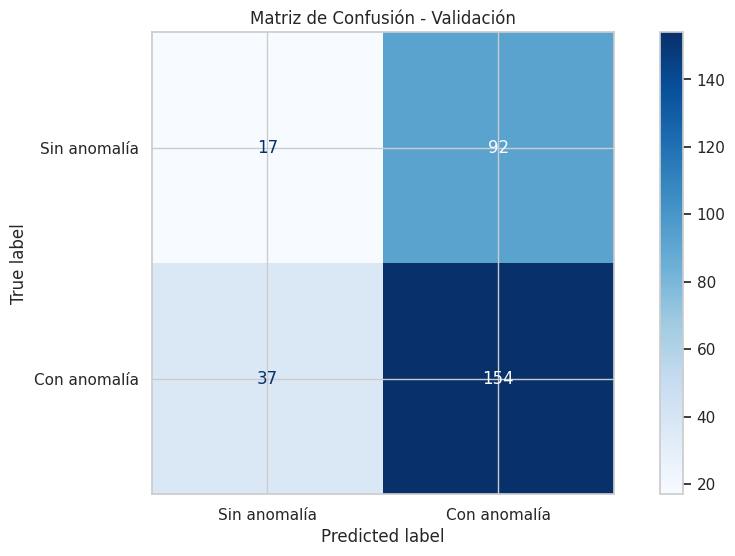

In [ ]:
# Mostrar matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sin anomalía", "Con anomalía"])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - Validación")
plt.show()

### Importancia de Variables

/tmp/ipython-input-2594285529.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


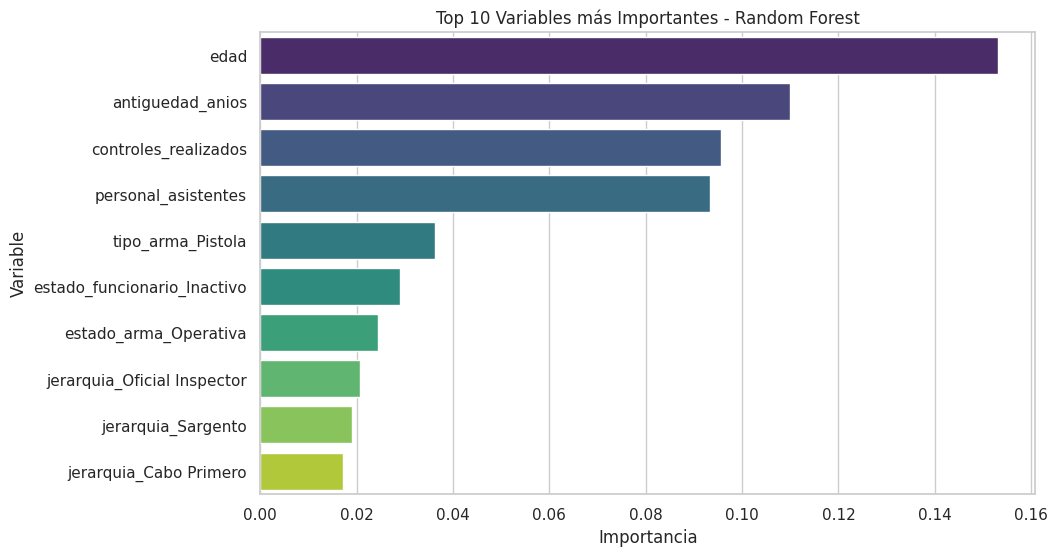

In [ ]:
import seaborn as sns

importances = rf_model.feature_importances_
feature_names = X_train.columns

# Mostrar 10 características más importantes
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title("Top 10 Variables más Importantes - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()

### Comparación Visual entre Reales y Predichos

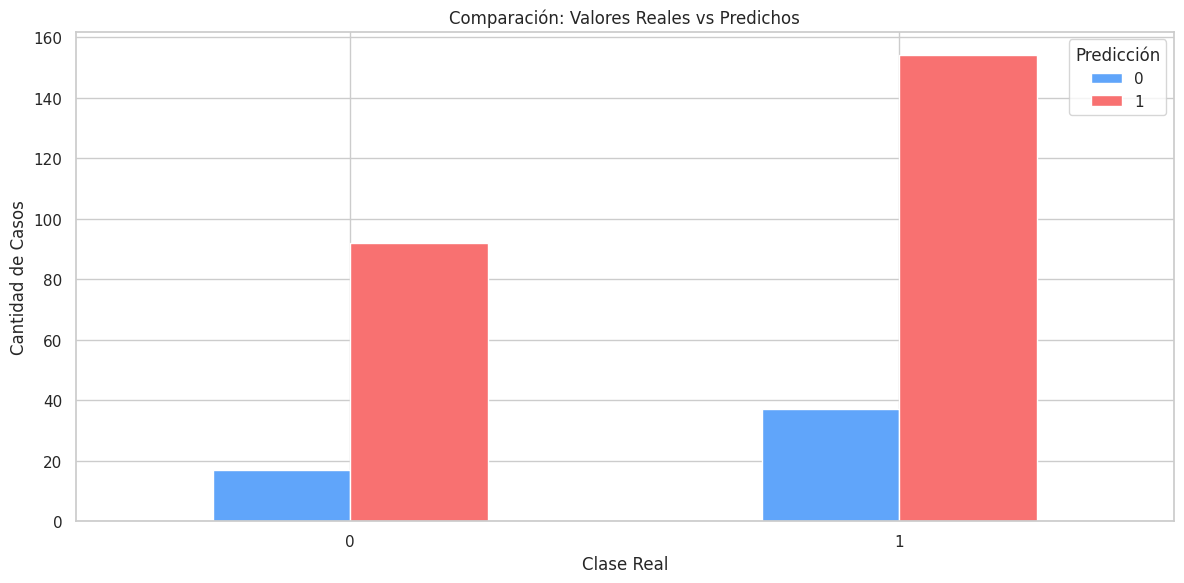

In [ ]:
import numpy as np

# Conteo de reales vs predichos
val_comparison = pd.DataFrame({'Real': y_val, 'Predicción': y_val_pred})

val_comparison.value_counts().unstack().plot(kind='bar', color=['#60A5FA', '#F87171'])
plt.title("Comparación: Valores Reales vs Predichos")
plt.xlabel("Clase Real")
plt.ylabel("Cantidad de Casos")
plt.xticks(rotation=0)
plt.legend(title="Predicción")
plt.tight_layout()
plt.show()